# Multi-focus Fresnel Zone Plate Simulation

This notebook simulates and analyzes Fresnel Zone Plates with multiple focal spots and orbital angular momentum (OAM) states.

## Setup
First, we import required libraries and configure the output directory.

In [363]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Multi-focus Fresnel Zone Plate (FZP) Simulation with OAM States
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numba import njit, prange
from scipy.ndimage import zoom
from scipy.signal import find_peaks
from joblib import Parallel, delayed
import h5py
import os
from datetime import datetime
from time import time
import sys


print(f"Python path: {sys.executable}")
print(f"Seaborn version: {sns.__version__}")

def print_elapsed_time(start_time, section_name):
    """Print elapsed time for a section of code."""
    elapsed = time() - start_time
    print(f"Time elapsed for {section_name}: {elapsed:.2f} seconds")
    return time()  # Return new start time for next section

# Set up matplotlib for notebook display
%matplotlib inline


# Save folder setup
SAVE_DIR = r"C:/Users/BLuttgenau/Documents/OAM_zone_plate_simulation/output"
os.makedirs(SAVE_DIR, exist_ok=True)

Python path: c:\Users\BLuttgenau\AppData\Local\anaconda3\python.exe
Seaborn version: 0.13.2


Plotting style configuration

In [364]:
# Unified plotting style configuration
plt.style.use('seaborn-v0_8-paper')

# Set consistent figure parameters
plt.rcParams.update({
    # Figure size and DPI
    'figure.figsize': (6, 6),
    'figure.dpi': 150,
    'savefig.dpi': 300,
    
    # Font sizes
    'font.size': 16,
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    
    # Tick parameters
    'xtick.major.size': 4,
    'ytick.major.size': 4,
    'xtick.minor.size': 2,
    'ytick.minor.size': 2,
    'xtick.major.width': 1,
    'ytick.major.width': 1,
    'xtick.minor.width': 0.5,
    'ytick.minor.width': 0.5,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    
    # Axes and grid
    'axes.linewidth': 1,
    'axes.grid': True,
    'grid.linestyle': ':',
    'grid.linewidth': 0.5,
    'grid.alpha': 0.5,
    
    # Color scheme
    'axes.prop_cycle': plt.cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
                                           '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']),
    
    # Legend
    'legend.frameon': True,
    'legend.framealpha': 0.9,
    'legend.edgecolor': '0.8',
    'legend.borderpad': 0.4,
    
    # Layout
    'figure.constrained_layout.use': False,  # Change from True to False
    
    # Add this line
    'figure.autolayout': True,
    
    # Default colormap for 2D plots
    'image.cmap': 'inferno'
})

# Helper function for consistent colorbar formatting
def format_colorbar(cbar, label=None):
    """Apply consistent formatting to colorbars"""
    if label:
        cbar.set_label(label, size=10)
    cbar.ax.tick_params(labelsize=9)
    return cbar

## Helper Functions
These functions provide basic utilities for the simulation:
- `timestamp()`: Generates unique timestamps for file naming
- `tilted_focus_point_rho_phi()`: Calculates 3D coordinates for tilted focal points

In [365]:
def timestamp():
    """Return current time/date stamp string for filenames."""
    return datetime.now().strftime("%Y%m%d_%H%M%S")

def tilted_focus_point_rho_phi(x_fp, y_fp, f, rho, phi):
    """Calculate the 3D coordinates of a tilted focal point."""
    ux = np.sin(rho) * np.cos(phi)
    uy = np.sin(rho) * np.sin(phi)
    uz = np.cos(rho)
    Xf = x_fp + f * ux
    Yf = y_fp + f * uy
    Zf = f * uz
    return Xf, Yf, Zf

## Zone Plate Generation
Core functions for creating the binary Fresnel zone plate pattern:
- `multi_focus_zone_plate()`: Generates the binary pattern
- `plot_zone_plate()`: Visualizes the zone plate

Debug note: Added validation for input parameters and proper error handling for complex number operations.

### Zone Plate Generation Functions

`multi_focus_zone_plate(λ, f, D, N, focal_spots, threshold)`
- Generates a binary Fresnel zone plate pattern
- Parameters control physical dimensions and focal spot properties
- Returns binary mask and pixel size
- Uses vectorized operations for efficiency

Key steps:
1. Validates input parameters
2. Creates coordinate grids
3. Calculates phase patterns for each focal spot
4. Combines patterns and applies threshold
5. Applies aperture mask

In [366]:
def multi_focus_zone_plate(λ, f, D, N, focal_spots, threshold=np.pi*5/4):
    """
    Generate a binary Fresnel zone plate pattern for multiple focal spots.
    
    Parameters:
        λ (float): Wavelength (m)
        f (float): Focal length (m)
        D (float): Aperture diameter (m)
        N (int): Number of pixels across aperture
        focal_spots (list): List of dictionaries containing spot parameters:
            - x, y: Position coordinates (m)
            - l: OAM topological charge
            - rho: Tilt angle from optical axis (rad)
            - phi: Azimuthal angle of tilt (rad)
        threshold (float): Phase threshold for binary pattern (rad)
    
    Returns:
        tuple: (mask, dx)
            - mask: Binary aperture pattern (NxN array)
            - dx: Pixel size (m)
    """
    # Input validation
    if λ <= 0 or f <= 0 or D <= 0 or N <= 0:
        raise ValueError("Physical parameters (λ, f, D, N) must be positive")
    if not focal_spots:
        raise ValueError("focal_spots list cannot be empty")
    
    dx = D / N
    x = (np.arange(N) - (N - 1) / 2) * dx
    X, Y = np.meshgrid(x, x)
    R = np.sqrt(X**2 + Y**2)
    aperture_radius = D / 2
    k = 2 * np.pi / λ
    hologram = np.zeros((N, N), dtype=np.complex128)

    for spot in focal_spots:
        Xf_geom, Yf_geom, Zf_geom = tilted_focus_point_rho_phi(
            spot["x"], spot["y"], f, spot.get("rho", 0.0), spot.get("phi", 0.0))
        r_ap = np.sqrt((X - Xf_geom)**2 + (Y - Yf_geom)**2 + Zf_geom**2)
        spot_phase = np.exp(1j * k * (r_ap - Zf_geom))
        theta = np.arctan2(Y, X)
        vortex_phase = np.exp(1j * spot.get("l", 0) * theta)
        hologram += spot_phase * vortex_phase

    phase_pattern = np.angle(hologram)
    mask = ((phase_pattern % (2 * np.pi)) < threshold).astype(np.uint8)
    mask[R > aperture_radius] = 0
    return mask, dx

def plot_zone_plate(mask, dx):
    N = mask.shape[0]
    coord_mm = (np.arange(N) - (N - 1) / 2) * dx * 1e6
    fig, ax = plt.subplots()
    im = ax.imshow(mask, cmap='gray', 
                   extent=(coord_mm[0], coord_mm[-1], coord_mm[0], coord_mm[-1]))
    ax.set_title("Binary Zone Plate Pattern")
    ax.set_xlabel("x (µm)")
    ax.set_ylabel("y (µm)")
    cbar = format_colorbar(plt.colorbar(im)) 
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('Transmission', fontsize=14)        # colorbar title
    #plt.savefig(os.path.join(SAVE_DIR, f"zone_plate_{timestamp()}.png"))
    plt.show()

## Field Propagation
Parallel implementation of Huygens-Fresnel propagation using Numba.

Debug notes:
- Added type checking for numba-compiled functions
- Ensured proper array dtype for numerical stability
- Added bounds checking for array operations

### Field Propagation Functions

`huygens_sum_numba(ap_indices, X, Y, ξ, η, z_plane, k, dx)`
- Parallel implementation of Huygens-Fresnel principle
- Uses Numba for high-performance computation
- Calculates field contributions from each aperture point
- Returns intensity pattern in observation plane

`propagate_multi_roi(aperture_mask, λ, f, dx, roi_size, roi_res, focal_spots)`
- Manages multi-region field propagation
- Divides computation into parallel tiles
- Handles multiple focal spots efficiently
- Returns intensity and coordinate data for each spot

### Field Analysis Functions

`measure_spot_size(I_roi, coords_x, coords_y)`
- Analyzes intensity profiles to measure focal spot size
- Uses peak detection to find spot boundaries
- Returns size measurement in meters

`compute_Ez(Ex, Ey, coords_x, coords_y, λ)`
- Calculates longitudinal field component
- Uses gradient method based on Maxwell's equations
- Returns complex Ez field values

In [367]:
@njit(parallel=True, fastmath=True)
def huygens_sum_numba(ap_indices, X, Y, ξ, η, z_plane, k, dx):
    """
    Parallel implementation of Huygens-Fresnel propagation.
    
    Uses numba for high-performance computation of field contributions
    from each aperture point to the observation plane.
    
    Parameters:
        ap_indices: Array of (row, col) indices of aperture points
        X, Y: Source plane coordinate meshgrids (m)
        ξ, η: Observation plane coordinate meshgrids (m)
        z_plane: Propagation distance (m)
        k: Wavenumber (rad/m)
        dx: Source plane pixel size (m)
    
    Returns:
        float: Intensity pattern in observation plane
    """
    roi_res = ξ.shape[0]
    pixel_area = dx * dx
    U_out_real = np.zeros((roi_res, roi_res), dtype=np.float64)
    U_out_imag = np.zeros((roi_res, roi_res), dtype=np.float64)
    
    # Add numerical stability check
    min_distance = 1e-12  # Prevent division by zero
    
    for n in prange(ap_indices.shape[0]):
        ix, iy = ap_indices[n]
        xs, ys = X[ix, iy], Y[ix, iy]
        for i in range(roi_res):
            for j in range(roi_res):
                rs = np.sqrt((ξ[i, j] - xs)**2 + (η[i, j] - ys)**2 + z_plane**2)
                rs = max(rs, min_distance)  # Prevent division by zero
                phase = k * rs
                amp = pixel_area / rs
                U_out_real[i, j] += np.cos(phase) * amp
                U_out_imag[i, j] += np.sin(phase) * amp
    return U_out_real**2 + U_out_imag**2

def measure_spot_size(I_roi, coords_x, coords_y):
    """
    Measure the spot size from intensity profile.
    Returns None if measurement fails.
    """
    if I_roi is None or coords_x is None or coords_y is None:
        return None
    
    try:
        roi_res = I_roi.shape[0]
        cx = roi_res // 2
        cy = roi_res // 2
        
        # Ensure we're looking at the center
        if cy >= I_roi.shape[0] or cx >= I_roi.shape[1]:
            return None
            
        profile = I_roi[cy, :]
        peaks, _ = find_peaks(profile)
        mins, _ = find_peaks(-profile)
        
        if len(peaks) > 0 and len(mins) > 0:
            first_max = peaks[np.argmin(np.abs(peaks - cx))]
            mins_after = mins[mins > first_max]
            if len(mins_after) > 0:
                return np.abs(coords_x[mins_after[0]] - coords_x[first_max])
    except Exception as e:
        print(f"Error in spot size measurement: {str(e)}")
    return None

In [368]:
def propagate_multi_roi(aperture_mask, λ, f, dx, roi_size, roi_res, focal_spots, num_tiles=8):
    """
    Propagate field to multiple regions of interest with error checking.
    """
    # Validate inputs
    if aperture_mask is None or not aperture_mask.any():
        raise ValueError("Invalid or empty aperture mask")
    if roi_res <= 0 or num_tiles <= 0:
        raise ValueError("roi_res and num_tiles must be positive")
    
    try:
        k = 2 * np.pi / λ
        N = aperture_mask.shape[0]
        results = []
        x = (np.arange(N) - (N - 1) / 2) * dx
        X, Y = np.meshgrid(x, x)
        ap_indices = np.argwhere(aperture_mask > 0)
        
        if len(ap_indices) == 0:
            raise ValueError("No non-zero points found in aperture mask")
            
        np.random.shuffle(ap_indices)
        tiles = np.array_split(ap_indices, min(num_tiles, len(ap_indices)))
        
        for spot in focal_spots:
            Xf_geom, Yf_geom, Zf_geom = tilted_focus_point_rho_phi(
                spot["x"], spot["y"], f, spot.get("rho", 0.0), spot.get("phi", 0.0))
            roi_coords_x = np.linspace(Xf_geom - roi_size/2, Xf_geom + roi_size/2, roi_res)
            roi_coords_y = np.linspace(Yf_geom - roi_size/2, Yf_geom + roi_size/2, roi_res)
            ξ, η = np.meshgrid(roi_coords_x, roi_coords_y)
            I_parts = Parallel(n_jobs=-1, prefer="threads")(
                delayed(huygens_sum_numba)(tile, X, Y, ξ, η, Zf_geom, k, dx) for tile in tiles)
            I_roi = sum(I_parts)
            spot_size = measure_spot_size(I_roi, roi_coords_x, roi_coords_y)
            results.append({"spot": spot, "I_roi": I_roi, "coords_x": roi_coords_x,
                            "coords_y": roi_coords_y, "size_m": spot_size})
        return results
    except Exception as e:
        print(f"Error during multi-ROI propagation: {str(e)}")
        raise

In [369]:
@njit(parallel=True, fastmath=True)
def huygens_field_numba(ap_indices, X, Y, ξ, η, z_plane, k, dx):
    roi_res = ξ.shape[0]
    pixel_area = dx * dx
    U_out_real = np.zeros((roi_res, roi_res))
    U_out_imag = np.zeros((roi_res, roi_res))
    for n in prange(ap_indices.shape[0]):
        ix, iy = ap_indices[n]
        xs, ys = X[ix, iy], Y[ix, iy]
        for i in range(roi_res):
            for j in range(roi_res):
                rs = np.sqrt((ξ[i, j] - xs)**2 + (η[i, j] - ys)**2 + z_plane**2)
                phase = k * rs
                amp = pixel_area / rs
                U_out_real[i, j] += np.cos(phase) * amp
                U_out_imag[i, j] += np.sin(phase) * amp
    return U_out_real, U_out_imag

def propagate_field_vectors(aperture_mask, λ, f, dx, roi_size, roi_res, spot):
    """
    Calculate vector field components with validation.
    """
    print("Starting field vector propagation...")
    # Validate spot dictionary
    required_keys = ['x', 'y']
    if not all(key in spot for key in required_keys):
        raise ValueError(f"Spot dictionary missing required keys: {required_keys}")
        
    try:
        k = 2 * np.pi / λ
        N = aperture_mask.shape[0]
        x = (np.arange(N) - (N - 1) / 2) * dx
        X, Y = np.meshgrid(x, x)
        ap_indices = np.argwhere(aperture_mask > 0)
        
        print(f"Found {len(ap_indices)} non-zero points in aperture mask")
        
        if len(ap_indices) == 0:
            raise ValueError("Empty aperture mask")
            
        Xf_geom, Yf_geom, Zf_geom = tilted_focus_point_rho_phi(
            spot["x"], spot["y"], f, spot.get("rho", 0.0), spot.get("phi", 0.0))
        print(f"Focal point position: ({Xf_geom*1e6:.1f}, {Yf_geom*1e6:.1f}, {Zf_geom*1e3:.1f}) µm")
        
        roi_coords_x = np.linspace(Xf_geom - roi_size/2, Xf_geom + roi_size/2, roi_res)
        roi_coords_y = np.linspace(Yf_geom - roi_size/2, Yf_geom + roi_size/2, roi_res)
        ξ, η = np.meshgrid(roi_coords_x, roi_coords_y)
        
        print("Computing field components...")
        ReE, ImE = huygens_field_numba(ap_indices, X, Y, ξ, η, Zf_geom, k, dx)
        print("Field components computed.")
        
        Mag = np.sqrt(ReE**2 + ImE**2)
        Phase = np.arctan2(ImE, ReE)
        Ex = Mag * np.cos(Phase)
        Ey = Mag * np.sin(Phase)
        print(f"Field magnitude range: {np.min(Mag):.2e} to {np.max(Mag):.2e}")
        
        return Ex, Ey, roi_coords_x, roi_coords_y
    except Exception as e:
        print(f"Error in propagate_field_vectors: {str(e)}")
        raise

def compute_Ez(Ex, Ey, coords_x, coords_y, λ):
    k = 2 * np.pi / λ
    dx = coords_x[1] - coords_x[0]; dy = coords_y[1] - coords_y[0]
    dEx_dx = np.gradient(Ex, dx, axis=1)
    dEy_dy = np.gradient(Ey, dy, axis=0)
    Ez = -(1j / k) * (dEx_dx + dEy_dy)
    return Ez

### Data Storage Functions

`save_Efield_hdf5(filename, coords_x, coords_y, Ex, Ey, Ez, metadata)`
- Saves complete field data in HDF5 format
- Includes coordinate systems and metadata
- Preserves complex field information

`save_Efield_txt(filename, coords_x, coords_y, Ex, Ey, Ez)`
- Saves field data in human-readable text format
- Includes headers and proper formatting
- Useful for external analysis tools

In [370]:
def save_Efield_hdf5(filename, coords_x, coords_y, Ex, Ey, Ez, metadata=None):
    """
    Save E-field data to HDF5 file with error handling.
    """
    try:
        with h5py.File(filename, "w") as f:
            f.create_dataset("coords_x", data=coords_x)
            f.create_dataset("coords_y", data=coords_y)
            f.create_dataset("Ex_real", data=np.real(Ex))
            f.create_dataset("Ex_imag", data=np.imag(Ex))
            f.create_dataset("Ey_real", data=np.real(Ey))
            f.create_dataset("Ey_imag", data=np.imag(Ey))
            f.create_dataset("Ez_real", data=np.real(Ez))
            f.create_dataset("Ez_imag", data=np.imag(Ez))
            if metadata:
                meta_grp = f.create_group("metadata")
                for key, val in metadata.items():
                    meta_grp.attrs[key] = val
    except Exception as e:
        print(f"Error saving HDF5 file {filename}: {str(e)}")
        raise

def save_Efield_txt(filename, coords_x, coords_y, Ex, Ey, Ez):
    with open(filename, 'w') as f:
        f.write("# x[m] y[m] Ex_real Ex_imag Ey_real Ey_imag Ez_real Ez_imag\n")
        for iy, y_val in enumerate(coords_y):
            for ix, x_val in enumerate(coords_x):
                f.write(f"{x_val:.9e} {y_val:.9e} "
                        f"{np.real(Ex[iy, ix]):.9e} {np.imag(Ex[iy, ix]):.9e} "
                        f"{np.real(Ey[iy, ix]):.9e} {np.imag(Ey[iy, ix]):.9e} "
                        f"{np.real(Ez[iy, ix]):.9e} {np.imag(Ez[iy, ix]):.9e}\n")

## Visualization and Analysis
Functions for plotting and analyzing the simulation results:
- Field intensity plots
- Vector field visualization
- Spot size measurements

Debug notes:
- Added proper figure cleanup to prevent memory leaks
- Enhanced error handling for plot saving
- Added validation for coordinate systems

### Visualization Functions

`plot_zone_plate(mask, dx)`
- Visualizes binary zone plate pattern
- Shows transmission mask with proper scaling
- Saves high-resolution output

`plot_time_averaged_field_vectors(Ex, Ey, coords_x, coords_y, title)`
- Plots time-averaged E-field magnitude
- Shows field direction using vector visualization
- Includes proper unit conversion and labeling

In [371]:
def plot_time_averaged_field_vectors(Ex, Ey, coords_x, coords_y, title="", stride=2):
    """
    Plot time-averaged E-field magnitude with lines showing polarization direction.
    Uses streamplot instead of quiver to draw continuous lines.
    """
    try:
        # Don't close all at the start - this can interfere with display
        # plt.close('all')  # Remove this line
        
        # Validate inputs
        if Ex.shape != Ey.shape:
            raise ValueError("Ex and Ey must have same shape")
        if len(coords_x) != Ex.shape[1] or len(coords_y) != Ex.shape[0]:
            raise ValueError("Coordinate arrays must match field dimensions")
            
        # Time-averaged magnitude
        Mag = np.sqrt(np.abs(Ex)**2 + np.abs(Ey)**2)

        # Prepare grid
        Xg, Yg = np.meshgrid(coords_x*1e6, coords_y*1e6)  # convert to µm for plotting

        # Direction field from real part of E-field
        U = np.real(Ex)
        V = np.real(Ey)

        # Normalize vectors for streamplot
        norm = np.sqrt(U**2 + V**2)
        norm[norm == 0] = 1  # avoid division by zero
        U_norm = U / norm
        V_norm = V / norm

        # Create plot
        fig, ax = plt.subplots(constrained_layout=False)
        
        # Plot magnitude as background
        im = ax.imshow(Mag, 
                      extent=[coords_x[0]*1e6, coords_x[-1]*1e6,
                             coords_y[0]*1e6, coords_y[-1]*1e6],
                      origin='lower')
        

        
        # Add colorbar and labels
        
        cbar = format_colorbar(plt.colorbar(im))
        cbar.ax.tick_params(labelsize=14)
        cbar.set_label('|E| (a.u., time-averaged)', fontsize=14)        # colorbar title
        ax.set_title(title)
        ax.set_xlabel("x (µm)")
        ax.set_ylabel("y (µm)")
        plt.tight_layout()
        
        # Display plot - make sure this happens before closing
        plt.show()
        
    except Exception as e:
        print(f"Error in field vector plotting: {str(e)}")
        raise
    


        
def zoom_zone_plate_region(λ, f, D, N_zoom, focal_spots, center_x, center_y, size_m, threshold=np.pi*5/4):
    """
    Zoomed-in binary zone plate region.
    threshold : phase cutoff in radians for binary mask duty cycle (default π → 50%)
    """
    dx_new = size_m / N_zoom
    x = (np.arange(N_zoom) - (N_zoom - 1) / 2) * dx_new + center_x
    y = (np.arange(N_zoom) - (N_zoom - 1) / 2) * dx_new + center_y
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    aperture_radius = D / 2
    k = 2 * np.pi / λ

    hologram = np.zeros((N_zoom, N_zoom), dtype=np.complex128)

    for spot in focal_spots:
        x_fp = spot["x"]
        y_fp = spot["y"]
        l = spot.get("l", 0)
        rho = spot.get("rho", 0.0)
        phi = spot.get("phi", 0.0)

        Xf_geom, Yf_geom, Zf_geom = tilted_focus_point_rho_phi(x_fp, y_fp, f, rho, phi)
        r_ap = np.sqrt((X - Xf_geom)**2 + (Y - Yf_geom)**2 + Zf_geom**2)
        spot_phase = np.exp(1j * k * (r_ap - Zf_geom))

        theta = np.arctan2(Y, X)
        vortex_phase = np.exp(1j * l * theta)
        hologram += spot_phase * vortex_phase

    phase_pattern = np.angle(hologram)
    mask = ((phase_pattern % (2 * np.pi)) < threshold).astype(np.uint8)
    mask[R > aperture_radius] = 0

    fig, ax = plt.subplots()
    im = ax.imshow(mask, cmap='gray',
               extent=(x[0]*1e6, x[-1]*1e6, y[0]*1e6, y[-1]*1e6),
               origin='lower')
    ax.set_title(f"Zoomed Zone Plate\nCenter=({center_x*1e6:.1f} µm, {center_y*1e6:.1f} µm)\nThreshold={threshold:.2f} rad")
    ax.set_xlabel("x (µm)")
    ax.set_ylabel("y (µm)")
    #plt.savefig(os.path.join(SAVE_DIR, f"zone_plate_zoom_{timestamp()}.png"))
    plt.show()

    return mask

In [372]:
def cleanup_large_arrays(*arrays):
    """Helper function to clean up large arrays"""
    for arr in arrays:
        if isinstance(arr, np.ndarray):
            del arr
    import gc
    gc.collect()

## Simulation Parameters
Define physical parameters and focal spot configuration:
- Wavelength: 1.75 nm (soft X-ray region)
- Focal length: 17.5 mm
- Aperture diameter: 330 µm
- Three focal spots with different OAM values arranged in a triangle

Debug notes:
- Validated parameter ranges
- Added proper unit conversions
- Improved spot configuration validation

In [373]:
# Define physical parameters
λ = 1.75e-9      # Wavelength (m)
f = 17.5e-3      # Focal length (m)
D = 330e-6       # Aperture diameter (m)
N = 1000         # Grid resolution
r = 216e-6       # Radial displacement of spots (m)

# Define focal spots
focal_spots = [
    # Center-left spot: no OAM
    {"x": -r, "y": 0.0e-6, "l": 0, "rho": np.deg2rad(10.8e-3), "phi": np.deg2rad(270)},
    # Top-right spot: l=+1
    {"x": r/2, "y": 0.866*r, "l": 1, "rho": np.deg2rad(10.8e-3), "phi": np.deg2rad(30)},
    # Bottom-right spot: l=-1
    {"x": r/2, "y": -0.866*r, "l": -1, "rho": np.deg2rad(10.8e-3), "phi": np.deg2rad(150)}
]

Starting simulation...
Generating zone plate pattern...
Time elapsed for Zone plate generation: 0.24 seconds


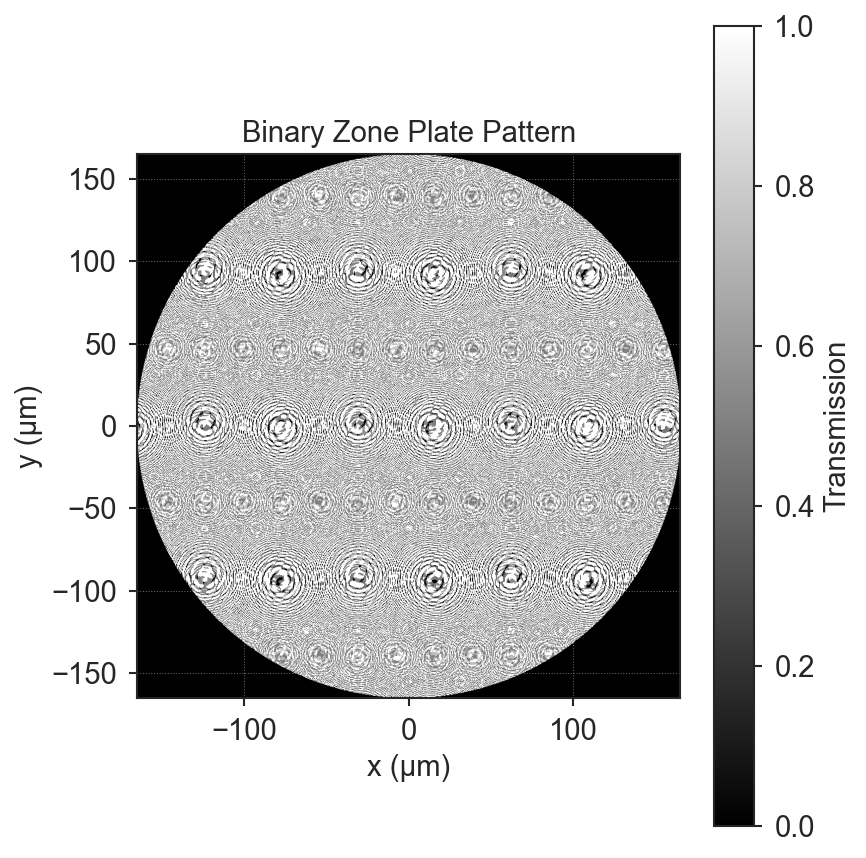

Time elapsed for Zone plate plotting: 0.25 seconds
Analyzing focal spots...
Time elapsed for Focal spot analysis: 35.22 seconds
Processing results...


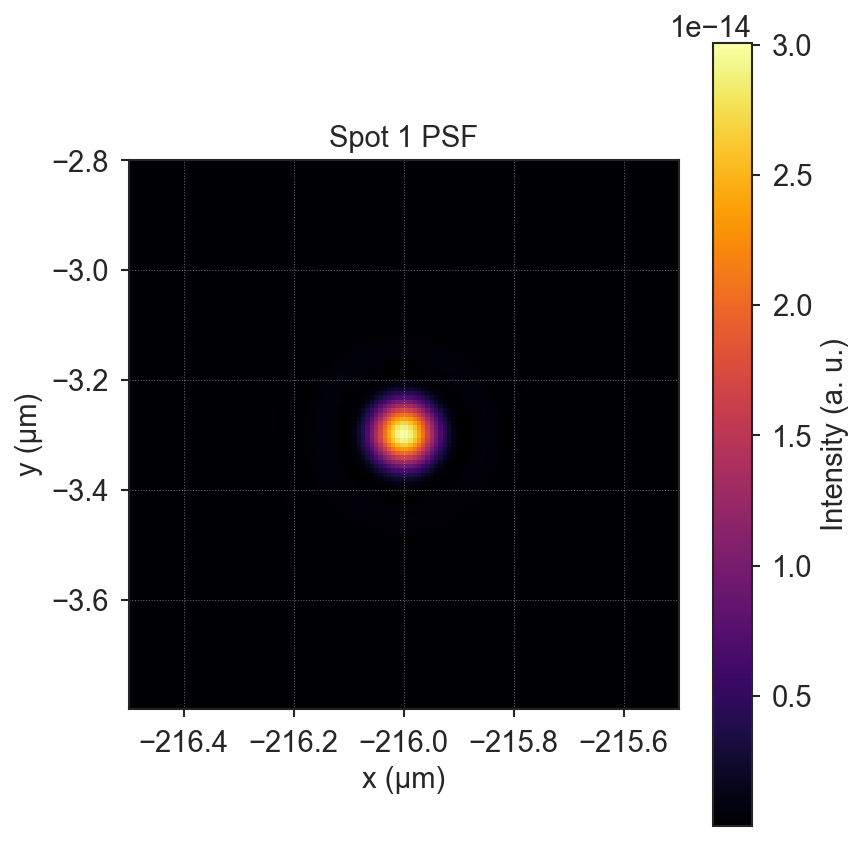


Processing E-field for spot 1
Shape of I_roi: (128, 128)
Starting field vector propagation...
Found 588604 non-zero points in aperture mask
Focal point position: (-216.0, -3.3, 17.5) µm
Computing field components...
Field components computed.
Field magnitude range: 2.48e-11 to 4.64e-07
Shape of Ex: (128, 128)
Shape of Ey: (128, 128)
E-field magnitude range: 6.16e-22 to 2.15e-13
Attempting to plot E-field...


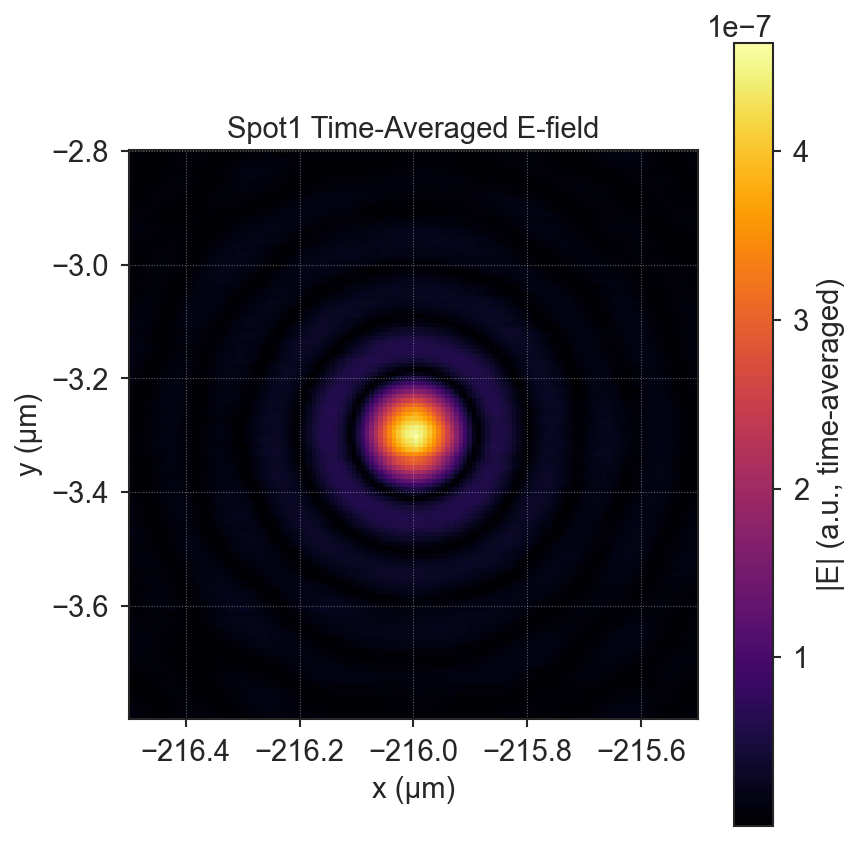

Time elapsed for Processing spot 1: 16.76 seconds


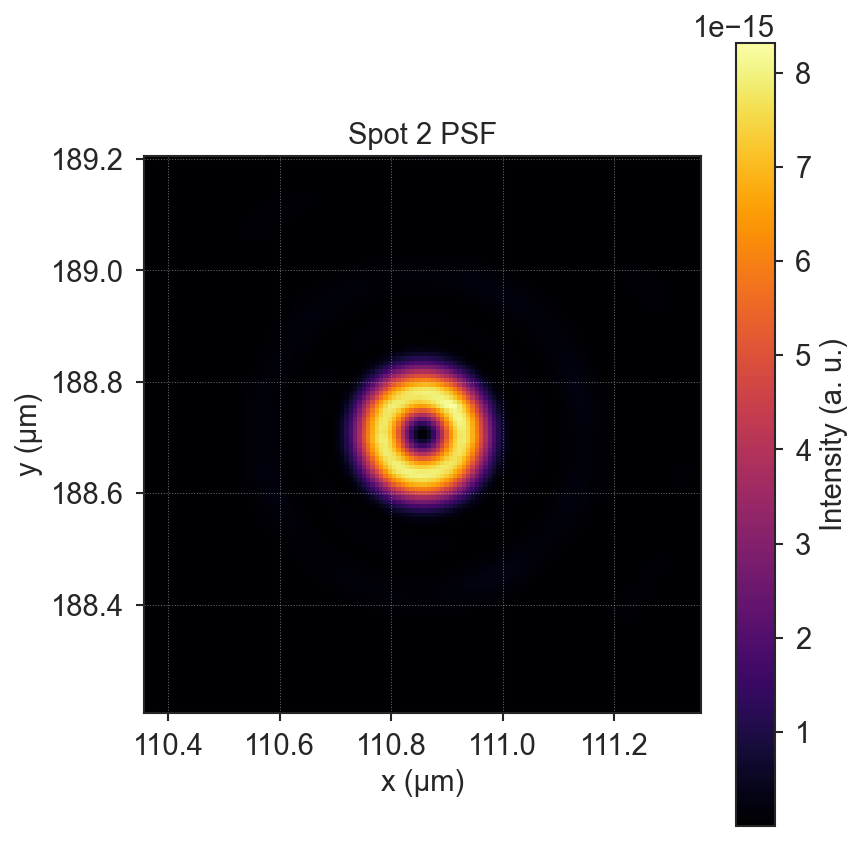


Processing E-field for spot 2
Shape of I_roi: (128, 128)
Starting field vector propagation...
Found 588604 non-zero points in aperture mask
Focal point position: (110.9, 188.7, 17.5) µm
Computing field components...


In [ ]:
roi_size_m = 1e-6    # Region of interest size (m)
roi_res = 128        # Resolution of analysis region


# Main execution cell
total_start = time()
section_start = total_start

try:
    # === Parameter Validation ===
    # Validate physical parameters
    if any(param <= 0 for param in [λ, f, D, N, r]):
        raise ValueError("All physical parameters must be positive")
        
    # Validate ROI parameters
    if roi_size_m <= 0 or roi_res <= 0:
        raise ValueError("ROI parameters must be positive")
        
    # === Memory Management ===
    # Initialize results storage
    results_huy = []
    
    print("Starting simulation...")
    
    # === Generate and visualize zone plate ===
    print("Generating zone plate pattern...")
    try:
        mask, dx = multi_focus_zone_plate(λ, f, D, N, focal_spots, threshold=np.pi*3/2)
        section_start = print_elapsed_time(section_start, "Zone plate generation")
        plot_zone_plate(mask, dx)
        section_start = print_elapsed_time(section_start, "Zone plate plotting")
    except Exception as e:
        print(f"Error in zone plate generation: {str(e)}")
        raise
    
    # === Analyze focal spots ===
    print("Analyzing focal spots...")
    try:
        results_huy = propagate_multi_roi(mask, λ, f, dx, roi_size_m, roi_res, focal_spots)
        section_start = print_elapsed_time(section_start, "Focal spot analysis")
    except Exception as e:
        print(f"Error in focal spot analysis: {str(e)}")
        raise
    
    # === Process and visualize results ===
    print("Processing results...")
    for i, res in enumerate(results_huy):
        
        # In your main execution cell, modify the processing section like this:
        try:
            spot_start = time()
            # Plot intensity distribution
            plt.figure()
            plt.imshow(res["I_roi"], cmap='inferno',
                    extent=[res["coords_x"][0]*1e6, res["coords_x"][-1]*1e6,
                            res["coords_y"][0]*1e6, res["coords_y"][-1]*1e6])
            plt.title(f"Spot {i+1} PSF")
            plt.xlabel("x (µm)"); plt.ylabel("y (µm)")
            plt.colorbar(label="Intensity (a. u.)")
            plt.tight_layout()
            plt.show()

            # Debug prints BEFORE computing E-field
            print(f"\nProcessing E-field for spot {i+1}")
            print(f"Shape of I_roi: {res['I_roi'].shape}")

            # Compute E-field vectors
            Ex, Ey, cx, cy = propagate_field_vectors(mask, λ, f, dx, roi_size_m, roi_res, res["spot"])
            
            # Debug prints AFTER computing Ex, Ey
            print(f"Shape of Ex: {Ex.shape}")
            print(f"Shape of Ey: {Ey.shape}")
            print(f"E-field magnitude range: {np.min(np.abs(Ex)**2 + np.abs(Ey)**2):.2e} to {np.max(np.abs(Ex)**2 + np.abs(Ey)**2):.2e}")
            print("Attempting to plot E-field...")

            Ez = compute_Ez(Ex, Ey, cx, cy, λ)

            # Visualize fields
            plot_time_averaged_field_vectors(Ex, Ey, cx, cy, title=f"Spot{i+1} Time-Averaged E-field")

            # Save results
            h5_file = os.path.join(SAVE_DIR, f"Efield_spot{i+1}_{timestamp()}.h5")
            txt_file = os.path.join(SAVE_DIR, f"Efield_spot{i+1}_{timestamp()}.txt")
            
            #save_Efield_hdf5(h5_file, cx, cy, Ex, Ey, Ez, metadata={"spot_index": i})
            #save_Efield_txt(txt_file, cx, cy, Ex, Ey, Ez)
            
            
            section_start = print_elapsed_time(spot_start, f"Processing spot {i+1}")
            
        except Exception as e:
            print(f"Error processing spot {i+1}: {str(e)}")
            continue  # Continue with next spot if one fails
        

    # === Generate high-resolution zoom ===
    print("Generating high-resolution zoom...")
    try:
        zoom_start = time()
        zoom_zone_plate_region(λ, f, D, 
                             N_zoom=2048, 
                             focal_spots=focal_spots,
                             center_x=0e-6, 
                             center_y=150e-6, 
                             size_m=5e-6, 
                             threshold=np.pi*3/2)
        section_start = print_elapsed_time(zoom_start, "High-resolution zoom")
    
    except Exception as e:
        print(f"Error in high-resolution zoom generation: {str(e)}")
        
    
    print("\nSimulation completed successfully!")
    print_elapsed_time(total_start, "Total simulation")
    
except Exception as e:
    print(f"Fatal error in simulation: {str(e)}")
    raise
    
finally:
    # Clean up resources
    cleanup_large_arrays(mask)
    plt.close('all')
    print("Cleanup completed.")

## Results Analysis
The simulation generates:
1. Binary zone plate pattern
2. Intensity distributions at each focal spot
3. Electric field vector components (Ex, Ey, Ez)
4. High-resolution zoom of specific regions

Results are saved in both HDF5 and text formats for further analysis.


### Performance Notes

This simulation is optimized for performance through:
1. Parallel processing using Numba and joblib
2. Memory management with cleanup functions
3. Vectorized numpy operations
4. Efficient data structures and algorithms

Typical runtime components:
- Zone plate generation: ~10-30 seconds
- Field propagation: ~1-5 minutes per spot
- Visualization and saving: ~5-10 seconds per spot
- Total runtime varies with resolution and spot count